In [81]:
%pip install sqlalchemy pandas matplotlib python-dotenv psycopg2 numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os

from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()

database_url = os.getenv("DATABASE_URL")

assert(database_url is not None and database_url != "")

engine = create_engine(database_url)

connection = engine.connect()

C:\Users\moon\AppData\Local\Temp\ipykernel_31392\4017881063.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pony_rating_df["rating"] = pony_rating_df["rating"].replace(rating_mapping)


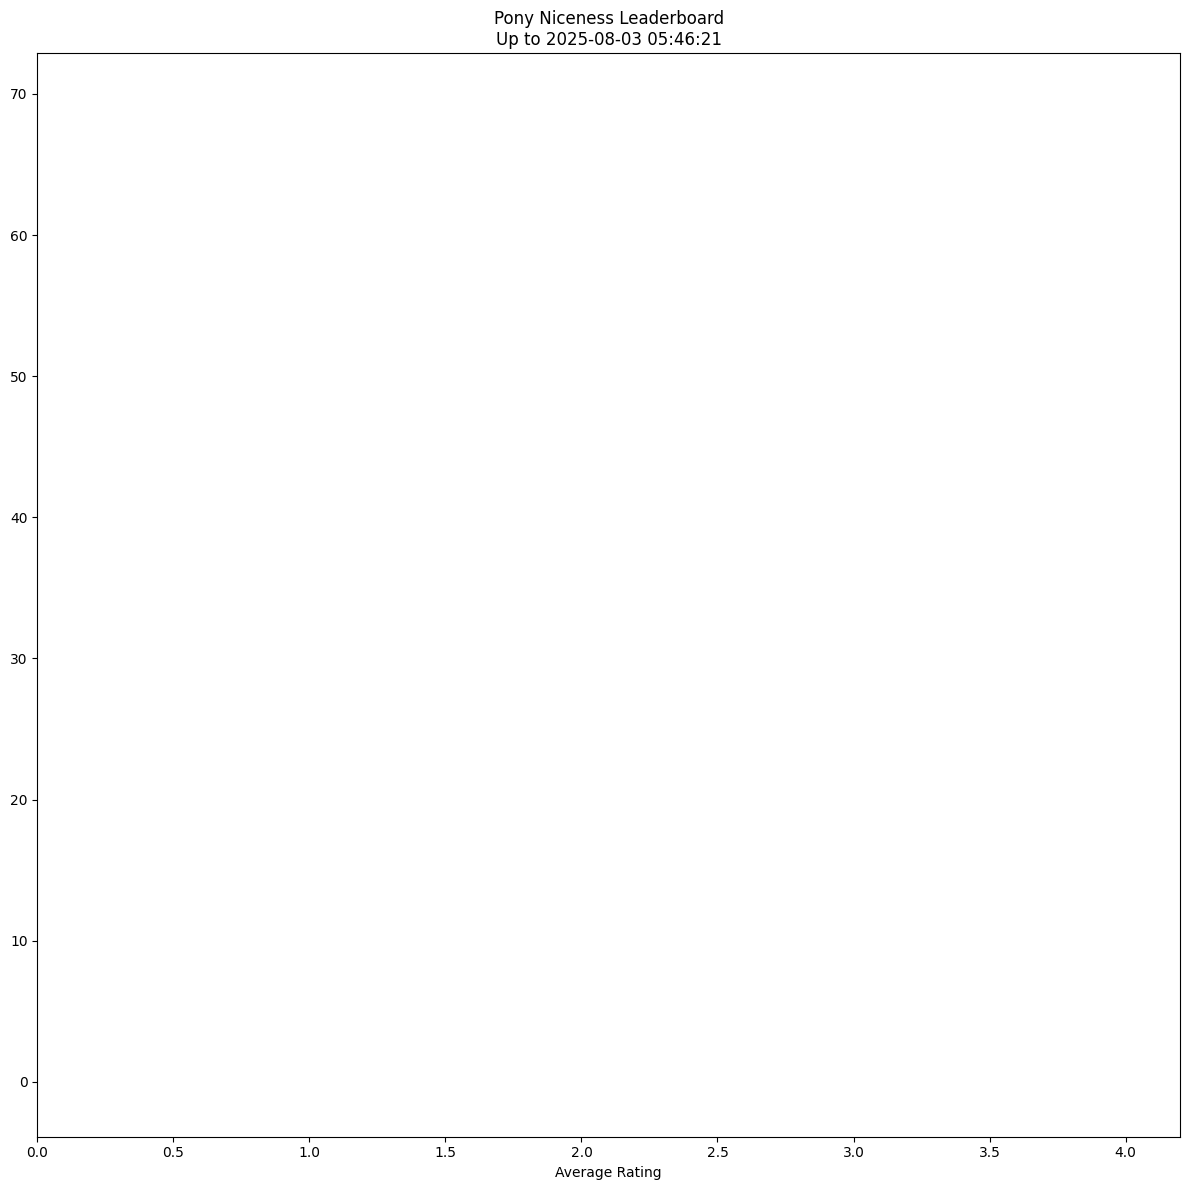

In [86]:
import itertools
from matplotlib import animation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rating_mapping = {"VERY_NICE": 4, "SOMEWHAT_NICE": 3, "NEITHER_NICE_NOR_MEAN": 2, "SOMEWHAT_MEAN": 1, "VERY_MEAN": 0}

pony_rating_df = pd.read_sql_query('SELECT name, "primaryColor", "PonyRating"."createdAt", "rating" FROM "PonyRating" INNER JOIN "Pony" ON "Pony"."id" = "PonyRating"."ponyId"', con=engine)
pony_rating_df = pony_rating_df[pony_rating_df["rating"] != "SKIPPED"]
pony_rating_df["rating"] = pony_rating_df["rating"].replace(rating_mapping)
pony_rating_df["createdAt"] = pd.to_datetime(pony_rating_df["createdAt"])
pony_rating_df = pony_rating_df.sort_values("createdAt")

# Step 2: Create time bins using linspace
start_time = pony_rating_df["createdAt"].min()
end_time = pony_rating_df["createdAt"].max()
num_frames = 600  # ~6 fps over 10 seconds (adjust if needed)

time_bins = pd.to_datetime(np.linspace(start_time.value, end_time.value, num=num_frames))

# Step 3: Build frame data
frames_data = []
for t in time_bins:
    filtered = pony_rating_df[pony_rating_df["createdAt"] <= t]
    mean_ratings = (
        filtered.groupby(["name", "primaryColor"], as_index=False)["rating"]
        .mean()
    )
    mean_ratings["frame_time"] = t
    frames_data.append(mean_ratings)

animated_df = pd.concat(frames_data).reset_index(drop=True)

# Step 4: Plotting
fig, ax = plt.subplots(figsize=(12, 12))

def draw_bar_race(t):
    ax.clear()
    frame = animated_df[animated_df["frame_time"] == t].sort_values("rating", ascending=True)
    bars = ax.barh(frame["name"], frame["rating"], color=frame["primaryColor"])
    ax.set_xlim(0, 4.2)
    ax.set_title(f"Pony Niceness Leaderboard\nUp to {t.strftime('%Y-%m-%d %H:%M:%S')}")
    ax.set_xlabel("Average Rating")
    plt.tight_layout()
    return bars

# Step 5: Animate and save
anim = animation.FuncAnimation(
    fig,
    lambda i: draw_bar_race(time_bins[i]),
    frames=len(time_bins),
    interval=10000 / num_frames,  # total duration = 10 sec
    blit=False,
    repeat=False
)

# Save to MP4
anim.save("pony_niceness_10s.mp4", writer="ffmpeg", fps=num_frames / 10)